In [1]:
import gym
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import time

In [3]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib

c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\Go\minic

In [4]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15730188212691266832
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16752138044600066719
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


### cross_entropy(Cartpole)

* 환경설정

In [62]:
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

def iter_batch(model,n_batch):
    cum_rs = []
    obs_a = []
    obs_s = []


    for i in range(n_batch):
        episo_a = []
        episo_s = []

        s = env.reset()
        # env.render()
        s = tf.convert_to_tensor([s],dtype=tf.float32)
        cum_r = 0

        while True:
            logits = model(s)
            m = tfp.distributions.Categorical(logits = logits)
            # a =     tf.math.reduce_mean(
            #         tf.reshape(m.sample(num_samples),[-1,num_samples]), axis=1, keepdims=False, name=None
            #     )
            if np.random.choice([True, False],p = [init_e,1-init_e]):
                a = np.random.choice(2,p = [0.5,0.5])
                ns, r, done, info = env.step(a)
                a = tf.convert_to_tensor([[a]],dtype=tf.int32)
                
            else:
                a = tf.reshape(m.sample(num_samples),[-1,num_samples])
                ns, r, done, info = env.step(a.numpy()[0][0])
                



            # ns, r, done, info = env.step(a.numpy()[0])

            episo_a.append(a)
            episo_s.append(s)

            s = tf.convert_to_tensor([ns],dtype=tf.float32)
            cum_r += 1
            if done:

                obs_a.append(tf.concat(episo_a,axis=0))
                obs_s.append(tf.concat(episo_s,axis=0))
                cum_rs.append(cum_r)
                break
    return cum_rs, obs_s, obs_a


# 환경 파라미터
env = gym.make('CartPole-v1')
# n_episode = 100

# 학습 파라미터
percentile = 70
epi_batch = 16
init_e = 0.3
lr_rate = 7 * 1e-3
# 모델 파라미터
hidden_structure= [64, 128,64]
input_shape= 4
output_shape= 2
act_function= 'relu'
num_samples = 1

# 모델
model = make_dense_model(hidden_structure,input_shape,act_function,output_shape)

# 옵티마이저
optimizer= keras.optimizers.Adam(learning_rate=lr_rate)

# 로스함수
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,)

In [63]:
@tf.function()
def train_actor_step(model,cum_rs,obs_s, obs_a):
  r_percentile = tfp.stats.percentile(cum_rs, q=percentile,axis=0)

  train_obs = []
  train_acts = []
  for i in range(len(cum_rs)):
      if cum_rs[i] >= r_percentile:
          train_obs.append(obs_s[i])
          train_acts.append(obs_a[i])

  # 값
  label = tf.concat(train_acts, axis=0)
  label = tf.reshape(label,[1,-1])[0]
#   label = tf.cast(label, tf.float64)

  # a = tf.cast(a, tf.float64)

  inputs = tf.concat(train_obs, axis=0)

  with tf.GradientTape(watch_accessed_variables=True) as tape: 
      logits = model(inputs)
      loss = loss_fun(label,logits)
      
      
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, sum(cum_rs) / len(cum_rs)

In [64]:
%%time
count = 0
n_run = 100
losses = []
reward_mean = []

for i in range(n_run):
    # count += 1
    # if count % 1 == 0:
    #     print(f"-run- [{count}]/[{n_run}]")
    init_e = init_e*0.95
    cum_rs,obs_s, obs_a = iter_batch(model,epi_batch)
    loss, reward_m = train_actor_step(model,cum_rs,obs_s, obs_a)
    losses.append(loss)
    reward_mean.append(reward_m)
    print(f'loss: {loss}, reward_mean: {reward_m}')

loss: 0.6937186121940613, reward_mean: 21.6875
loss: 0.6913864612579346, reward_mean: 19.875
loss: 0.6818053722381592, reward_mean: 19.875
loss: 0.7023694515228271, reward_mean: 17.875
loss: 0.6911346912384033, reward_mean: 22.3125
loss: 0.6930364370346069, reward_mean: 22.6875
loss: 0.6930072903633118, reward_mean: 22.0
loss: 0.6916108727455139, reward_mean: 21.375
loss: 0.6923059821128845, reward_mean: 24.1875
loss: 0.6926834583282471, reward_mean: 22.875
loss: 0.6890262961387634, reward_mean: 22.0
loss: 0.6993377208709717, reward_mean: 19.875
loss: 0.6910521984100342, reward_mean: 23.875
loss: 0.689993143081665, reward_mean: 26.125
loss: 0.6909906268119812, reward_mean: 18.5
loss: 0.6893969178199768, reward_mean: 26.0
loss: 0.696651816368103, reward_mean: 20.25
loss: 0.6896841526031494, reward_mean: 29.875
loss: 0.6972519755363464, reward_mean: 23.75
loss: 0.6927167177200317, reward_mean: 20.9375
loss: 0.6903048157691956, reward_mean: 21.1875
loss: 0.6906810998916626, reward_mean: 1

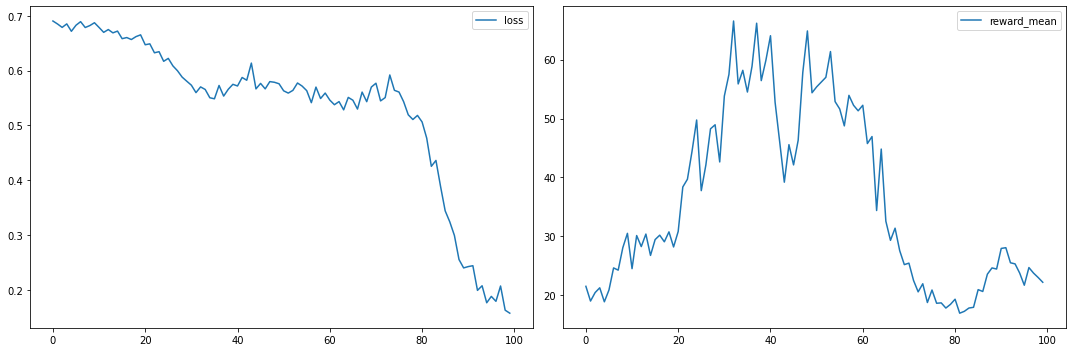

In [257]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(losses, label='loss')
axes[0].legend()
axes[1].plot(reward_mean, label='reward_mean')
axes[1].legend()
fig.tight_layout()

### cross entropy + offpolicy (메모리 버퍼 사용) +  입실론(점차 감소)

In [7]:
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

def iter_batch(model,n_batch):
    cum_rs = []
    obs_a = []
    obs_s = []


    for i in range(n_batch):
        episo_a = []
        episo_s = []

        s = env.reset()
        env.render()
        s = tf.convert_to_tensor([s],dtype=tf.float32)
        cum_r = 0

        while True:
            logits = model(s)
            m = tfp.distributions.Categorical(logits = logits)
            # a =     tf.math.reduce_mean(
            #         tf.reshape(m.sample(num_samples),[-1,num_samples]), axis=1, keepdims=False, name=None
            #     )
            if np.random.choice([True, False],p = [init_e,1-init_e]):
                a = np.random.choice(2,p = [0.5,0.5])
                ns, r, done, info = env.step(a)
                env.render()
                a = tf.convert_to_tensor([[a]],dtype=tf.int32)
                
            else:
                a = tf.reshape(m.sample(num_samples),[-1,num_samples])
                ns, r, done, info = env.step(a.numpy()[0][0])
                env.render()
                



            # ns, r, done, info = env.step(a.numpy()[0])

            episo_a.append(a)
            episo_s.append(s)

            s = tf.convert_to_tensor([ns],dtype=tf.float32)
            cum_r += 1
            if done:

                obs_a.append(tf.concat(episo_a,axis=0))
                obs_s.append(tf.concat(episo_s,axis=0))
                cum_rs.append(cum_r)
                break
    return cum_rs, obs_s, obs_a


# 환경 파라미터
env = gym.make('CartPole-v1')
# n_episode = 100

# 학습 파라미터
percentile = 70
epi_batch = 16
init_e = 0.3
lr_rate = 7 * 1e-3
# 모델 파라미터
hidden_structure= [64, 128,256,128,64]
input_shape= 4
output_shape= 2
act_function= 'relu'
num_samples = 1

# 모델
model = make_dense_model(hidden_structure,input_shape,act_function,output_shape)

# 옵티마이저
optimizer= keras.optimizers.Adam(learning_rate=lr_rate)

# 로스함수
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,)

In [8]:
@tf.function()
def train_actor_step(model,cum_rs,obs_s, obs_a):
  r_percentile = tfp.stats.percentile(cum_rs, q=percentile,axis=0)

  train_obs = []
  train_acts = []
  for i in range(len(cum_rs)):
      if cum_rs[i] >= r_percentile:
          train_obs.append(obs_s[i])
          train_acts.append(obs_a[i])

  # 값
  label = tf.concat(train_acts, axis=0)
  label = tf.reshape(label,[1,-1])[0]
  # label = tf.cast(label, tf.float64)

  # a = tf.cast(a, tf.float64)

  inputs = tf.concat(train_obs, axis=0)

  with tf.GradientTape(watch_accessed_variables=True) as tape: 
      logits = model(inputs)
      loss = loss_fun(label,logits)
      
      
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, sum(cum_rs) / len(cum_rs)

In [9]:
%%time
count = 0
n_run = 100
losses = []
reward_mean = []
buffer = {
    'cums' : [],
    'obs' : [],
    'acts' : [],
}


# init_e = init_e*0.96
# buffer['cums'],buffer['obs'], buffer['acts'] = iter_batch(model,epi_batch)

# ##
# loss, reward_m = train_actor_step(model = model,cum_rs = buffer['cums'],obs_s = buffer['obs'], obs_a = buffer['acts'])
# losses.append(loss)
# reward_mean.append(reward_m)
# print(f'loss: {loss}, reward_mean: {reward_m}')
for i in range(n_run):
    # count += 1
    # if count % 1 == 0:
    #     print(f"-run- [{count}]/[{n_run}]")
    init_e = init_e*0.95
    cum_rs,obs_s, obs_a = iter_batch(model,epi_batch)
    ##
    if i == 0 :
        buffer['cums'].extend(cum_rs)
        buffer['obs'].extend(obs_s)
        buffer['acts'].extend(obs_a)
    else:
        r_percentile = tfp.stats.percentile(buffer['cums'], q=percentile,axis=0)
        for i in range(len(cum_rs)):
            if cum_rs[i] >= r_percentile:
                buffer['cums'].append(cum_rs[i])
                buffer['obs'].append(obs_s[i])
                buffer['acts'].append(obs_a[i])

    ##
    loss, reward_m = train_actor_step(model = model,cum_rs = buffer['cums'],obs_s = buffer['obs'], obs_a = buffer['acts'])
    losses.append(loss)
    reward_mean.append(reward_m)
    print(f'loss: {loss}, reward_mean: {reward_m}')

loss: 0.6907315850257874, reward_mean: 19.3125
loss: 0.7013060450553894, reward_mean: 21.15999984741211
loss: 0.7004154920578003, reward_mean: 23.935483932495117
loss: 0.693257749080658, reward_mean: 25.11111068725586
loss: 0.6913477778434753, reward_mean: 25.216217041015625
loss: 0.6907833218574524, reward_mean: 27.095237731933594
loss: 0.6902609467506409, reward_mean: 28.0
loss: 0.6894760727882385, reward_mean: 28.89583396911621
loss: 0.6889280080795288, reward_mean: 29.73469352722168
loss: 0.6880411505699158, reward_mean: 29.84000015258789
loss: 0.687146782875061, reward_mean: 30.038461685180664
loss: 0.6860003471374512, reward_mean: 30.38888931274414
loss: 0.6849004626274109, reward_mean: 31.65517234802246
loss: 0.6833944320678711, reward_mean: 32.75806427001953
loss: 0.6821068525314331, reward_mean: 34.208953857421875
loss: 0.6798105239868164, reward_mean: 35.26760482788086
loss: 0.6780853271484375, reward_mean: 37.08000183105469
loss: 0.6807175874710083, reward_mean: 37.779220581

KeyboardInterrupt: 

: 

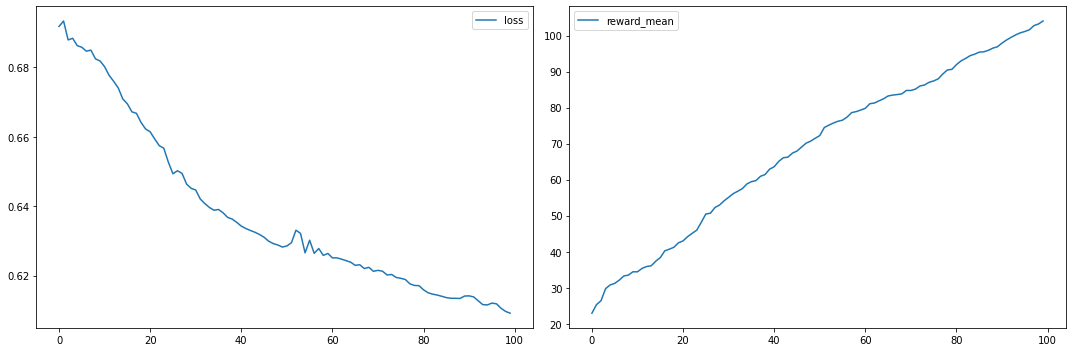

In [57]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(losses, label='loss')
axes[0].legend()
axes[1].plot(reward_mean, label='reward_mean')
axes[1].legend()
fig.tight_layout()

### cross entropy + offpolicy (메모리 버퍼 사용) +  입실론(일정)

In [58]:
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

def iter_batch(model,n_batch):
    cum_rs = []
    obs_a = []
    obs_s = []


    for i in range(n_batch):
        episo_a = []
        episo_s = []

        s = env.reset()
        # env.render()
        s = tf.convert_to_tensor([s],dtype=tf.float32)
        cum_r = 0

        while True:
            logits = model(s)
            m = tfp.distributions.Categorical(logits = logits)
            # a =     tf.math.reduce_mean(
            #         tf.reshape(m.sample(num_samples),[-1,num_samples]), axis=1, keepdims=False, name=None
            #     )
            if np.random.choice([True, False],p = [init_e,1-init_e]):
                a = np.random.choice(2,p = [0.5,0.5])
                ns, r, done, info = env.step(a)
                a = tf.convert_to_tensor([[a]],dtype=tf.int32)
                
            else:
                a = tf.reshape(m.sample(num_samples),[-1,num_samples])
                ns, r, done, info = env.step(a.numpy()[0][0])
                



            # ns, r, done, info = env.step(a.numpy()[0])

            episo_a.append(a)
            episo_s.append(s)

            s = tf.convert_to_tensor([ns],dtype=tf.float32)
            cum_r += 1
            if done:

                obs_a.append(tf.concat(episo_a,axis=0))
                obs_s.append(tf.concat(episo_s,axis=0))
                cum_rs.append(cum_r)
                break
    return cum_rs, obs_s, obs_a


# 환경 파라미터
env = gym.make('CartPole-v1')
# n_episode = 100

# 학습 파라미터
percentile = 70
epi_batch = 16
init_e = 0.3
lr_rate = 7 * 1e-3
# 모델 파라미터
hidden_structure= [64, 128,256,128,64]
input_shape= 4
output_shape= 2
act_function= 'relu'
num_samples = 1

# 모델
model = make_dense_model(hidden_structure,input_shape,act_function,output_shape)

# 옵티마이저
optimizer= keras.optimizers.Adam(learning_rate=lr_rate)

# 로스함수
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,)

In [59]:
@tf.function()
def train_actor_step(model,cum_rs,obs_s, obs_a):
  r_percentile = tfp.stats.percentile(cum_rs, q=percentile,axis=0)

  train_obs = []
  train_acts = []
  for i in range(len(cum_rs)):
      if cum_rs[i] >= r_percentile:
          train_obs.append(obs_s[i])
          train_acts.append(obs_a[i])

  # 값
  label = tf.concat(train_acts, axis=0)
  label = tf.reshape(label,[1,-1])[0]
  # label = tf.cast(label, tf.float64)

  # a = tf.cast(a, tf.float64)

  inputs = tf.concat(train_obs, axis=0)

  with tf.GradientTape(watch_accessed_variables=True) as tape: 
      logits = model(inputs)
      loss = loss_fun(label,logits)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, sum(cum_rs) / len(cum_rs)

In [60]:
%%time
count = 0
n_run = 100
losses = []
reward_mean = []
buffer = {
    'cums' : [],
    'obs' : [],
    'acts' : [],
}


# init_e = init_e*0.96
# buffer['cums'],buffer['obs'], buffer['acts'] = iter_batch(model,epi_batch)

# ##
# loss, reward_m = train_actor_step(model = model,cum_rs = buffer['cums'],obs_s = buffer['obs'], obs_a = buffer['acts'])
# losses.append(loss)
# reward_mean.append(reward_m)
# print(f'loss: {loss}, reward_mean: {reward_m}')
for i in range(n_run):
    # count += 1
    # if count % 1 == 0:
    #     print(f"-run- [{count}]/[{n_run}]")
    # init_e = init_e*0.95
    cum_rs,obs_s, obs_a = iter_batch(model,epi_batch)
    ##
    if i == 0 :
        buffer['cums'].extend(cum_rs)
        buffer['obs'].extend(obs_s)
        buffer['acts'].extend(obs_a)
    else:
        r_percentile = tfp.stats.percentile(buffer['cums'], q=percentile,axis=0)
        for i in range(len(cum_rs)):
            if cum_rs[i] >= r_percentile:
                buffer['cums'].append(cum_rs[i])
                buffer['obs'].append(obs_s[i])
                buffer['acts'].append(obs_a[i])

    ##
    loss, reward_m = train_actor_step(model = model,cum_rs = buffer['cums'],obs_s = buffer['obs'], obs_a = buffer['acts'])
    losses.append(loss)
    reward_mean.append(reward_m)
    print(f'loss: {loss}, reward_mean: {reward_m}')

loss: 0.6932365894317627, reward_mean: 19.3125
loss: 0.7011023759841919, reward_mean: 21.399999618530273
loss: 0.7191824913024902, reward_mean: 22.66666603088379
loss: 0.6892340183258057, reward_mean: 25.074073791503906
loss: 0.6905683279037476, reward_mean: 27.542856216430664
loss: 0.691455602645874, reward_mean: 28.794872283935547
loss: 0.6903347373008728, reward_mean: 29.170732498168945
loss: 0.6902163028717041, reward_mean: 31.326086044311523
loss: 0.6892126202583313, reward_mean: 32.0
loss: 0.6887794137001038, reward_mean: 32.57692337036133
loss: 0.6892483234405518, reward_mean: 33.16666793823242
loss: 0.687222421169281, reward_mean: 33.48214340209961
loss: 0.6866573095321655, reward_mean: 34.72881317138672
loss: 0.685119092464447, reward_mean: 35.93650817871094
loss: 0.684175431728363, reward_mean: 36.09375
loss: 0.6815850138664246, reward_mean: 38.37681198120117
loss: 0.6806381940841675, reward_mean: 38.79999923706055
loss: 0.679363489151001, reward_mean: 39.38356018066406
loss:

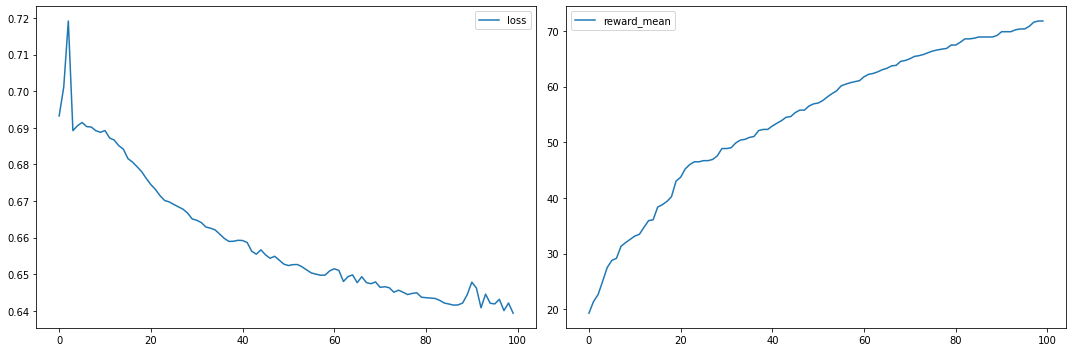

In [61]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(losses, label='loss')
axes[0].legend()
axes[1].plot(reward_mean, label='reward_mean')
axes[1].legend()
fig.tight_layout()